In this notebook i'll use the sklearn pipeline for the ML project development.

The data i'm using was cleaned using this notebook : https://github.com/RaphaelRoriz/Machine_learning/blob/master/housesPricesDataset/House%20Prices%20regressions.ipynb


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score  
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor as xgbr
from sklearn.svm import SVR
from sklearn.linear_model import Lasso

%matplotlib inline

/home/raphael/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/raphael/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/home/raphael/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


# Functions

In [63]:
def scores_train(model,model_predictions_train):
    print('Scores on training data:')
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, model_predictions_train)))
    print('R2 score:', model.score(X_train,y_train))

In [64]:
def scores_test(model,model_predictions_test):
    print('Scores on test data:')
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, model_predictions_test)))
    print('R2 score:', model.score(X_test,y_test))

In [4]:
def plot_train_test_predictions(model_name,model_predictions_train,model_predictions_test):
    
    plt.scatter(model_predictions_train, y_train, c = "blue",  label = "Training data")
    plt.scatter(model_predictions_test, y_test, c = "black",  label = "Test data")
    plt.title(model_name)
    plt.xlabel("Predicted values")
    plt.ylabel("Real values")
    plt.legend(loc = "upper left")
    plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
    plt.show()

In [5]:
def plot_y_predictions(model_name,model_predictions_train,model_predictions_test):
    
    test_fig = plt.figure()
    plt.plot(y_test,c= 'green',label = 'Y test',marker = 'o',linestyle = 'None')
    plt.plot(model_predictions_test,c= 'red',label = 'Test predictions',marker = 'o',linestyle = 'None')
    plt.title(model_name + '(test)')
    plt.ylabel('SalePrice')
    plt.legend(loc = "upper right")
    plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
    test_fig.show()
    
    train_fig = plt.figure()
    plt.plot(y_train,c= 'green',label = 'Y train',marker = 'o',linestyle = 'None')
    plt.plot(model_predictions_train,c= 'red',label = 'Train predictions',marker = 'o',linestyle = 'None')
    plt.title(model_name+'(Train)')
    plt.ylabel('SalePrice')
    plt.legend(loc = "upper right")
    plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
    train_fig.show()

# Importing data

In [6]:
houses_train = pd.read_pickle('houses_train_cleaned.pkl')
houses_test = pd.read_pickle('houses_test_cleaned.pkl')
houses_train.drop('Id',axis =1,inplace =True )

# Feature selection

I'll select the features based on the correlation with the target 

In [7]:
houses_train_corr = houses_train.corr()

In [8]:
salePrice_corr = houses_train_corr['SalePrice']

In [9]:
relevant_salePrice_corr = []

#here well searching for relevation correlations , ill consider a correlation relevant if its >= 0.5 and <= -0.5
for (columnName, columnData) in houses_train_corr['SalePrice'].iteritems():
    if columnData >= 0.5 or columnData <= -0.5: #0.5 is the corr that i got the best results
        relevant_salePrice_corr.append((columnName,columnData))

In [10]:
relevant_salePrice_corr

[('OverallQual', 0.7909816005838047),
 ('YearBuilt', 0.5228973328794967),
 ('YearRemodAdd', 0.5071009671113867),
 ('TotalBsmtSF', 0.6135805515591944),
 ('1stFlrSF', 0.6058521846919166),
 ('GrLivArea', 0.7086244776126511),
 ('FullBath', 0.5606637627484452),
 ('TotRmsAbvGrd', 0.5337231555820238),
 ('GarageCars', 0.640409197258349),
 ('GarageArea', 0.6234314389183598),
 ('SalePrice', 1.0),
 ('TotalConstructedSF', 0.809741322904717),
 ('TotalBath', 0.6317310679319897),
 ('ExterQual_TA', -0.589043523409763),
 ('KitchenQual_TA', -0.5192978536548846)]

In [11]:
#We'll not use the GarageArea column because it may be too much correlated to GarageCars
houses_train_corr['GarageArea']['GarageCars']

0.8824754142814603

In [12]:
relevant_columns_names_train = []
for i in relevant_salePrice_corr:
    relevant_columns_names_train.append(i[0])

In [13]:
relevant_columns_names_train.remove('GarageArea')

In [14]:
relevant_columns_names_train

['OverallQual',
 'YearBuilt',
 'YearRemodAdd',
 'TotalBsmtSF',
 '1stFlrSF',
 'GrLivArea',
 'FullBath',
 'TotRmsAbvGrd',
 'GarageCars',
 'SalePrice',
 'TotalConstructedSF',
 'TotalBath',
 'ExterQual_TA',
 'KitchenQual_TA']

In [15]:
houses_train  = houses_train[relevant_columns_names_train]

In [16]:
houses_train

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,SalePrice,TotalConstructedSF,TotalBath,ExterQual_TA,KitchenQual_TA
0,7,2003,2003,856.0,856,1710,2,8,2.0,208500.0,3175.0,3.5,0,0
1,6,1976,1976,1262.0,1262,1262,2,6,2.0,181500.0,3282.0,2.5,1,1
2,7,2001,2002,920.0,920,1786,2,6,2.0,223500.0,3356.0,3.5,0,0
3,7,1915,1970,756.0,961,1717,1,7,3.0,140000.0,3422.0,2.0,1,0
4,8,2000,2000,1145.0,1145,2198,2,9,3.0,250000.0,4455.0,3.5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,6,1999,2000,953.0,953,1647,2,7,2.0,175000.0,3100.0,2.5,1,1
1456,6,1978,1988,1542.0,2073,2073,2,7,2.0,210000.0,4464.0,3.0,1,1
1457,7,1941,2006,1152.0,1188,2340,2,9,1.0,266500.0,3804.0,2.0,0,0
1458,5,1950,1996,1078.0,1078,1078,1,5,1.0,142125.0,2874.0,2.0,1,0


In [17]:
houses_test

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1461,20,80.0,11622,5,6,1961,1961,0.0,468.0,...,0,0,0,0,1,0,0,0,1,0
1,1462,20,81.0,14267,6,6,1958,1958,108.0,923.0,...,0,0,0,0,1,0,0,0,1,0
2,1463,60,74.0,13830,5,5,1997,1998,0.0,791.0,...,0,0,0,0,1,0,0,0,1,0
3,1464,60,78.0,9978,6,6,1998,1998,20.0,602.0,...,0,0,0,0,1,0,0,0,1,0
4,1465,120,43.0,5005,8,5,1992,1992,0.0,263.0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,21.0,1936,4,7,1970,1970,0.0,0.0,...,0,0,0,0,1,0,0,0,1,0
1455,2916,160,21.0,1894,4,5,1970,1970,0.0,252.0,...,0,0,0,0,1,0,0,0,0,0
1456,2917,20,160.0,20000,5,7,1960,1996,0.0,1224.0,...,0,0,0,0,1,0,0,0,0,0
1457,2918,85,62.0,10441,5,5,1992,1992,0.0,337.0,...,0,0,0,0,1,0,0,0,1,0


# Test dataset for Kaggle submissions

In [18]:
relevant_columns_names_test = relevant_columns_names_train.remove('SalePrice')
houses_test = houses_test[relevant_columns_names_train]

In [19]:
houses_train

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,SalePrice,TotalConstructedSF,TotalBath,ExterQual_TA,KitchenQual_TA
0,7,2003,2003,856.0,856,1710,2,8,2.0,208500.0,3175.0,3.5,0,0
1,6,1976,1976,1262.0,1262,1262,2,6,2.0,181500.0,3282.0,2.5,1,1
2,7,2001,2002,920.0,920,1786,2,6,2.0,223500.0,3356.0,3.5,0,0
3,7,1915,1970,756.0,961,1717,1,7,3.0,140000.0,3422.0,2.0,1,0
4,8,2000,2000,1145.0,1145,2198,2,9,3.0,250000.0,4455.0,3.5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,6,1999,2000,953.0,953,1647,2,7,2.0,175000.0,3100.0,2.5,1,1
1456,6,1978,1988,1542.0,2073,2073,2,7,2.0,210000.0,4464.0,3.0,1,1
1457,7,1941,2006,1152.0,1188,2340,2,9,1.0,266500.0,3804.0,2.0,0,0
1458,5,1950,1996,1078.0,1078,1078,1,5,1.0,142125.0,2874.0,2.0,1,0


In [20]:
houses_test

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,TotalConstructedSF,TotalBath,ExterQual_TA,KitchenQual_TA
0,5,1961,1961,882.0,896,896,1,5,1.0,2768.0,1.0,1,1
1,6,1958,1958,1329.0,1329,1329,1,6,1.0,3399.0,1.5,1,0
2,5,1997,1998,928.0,928,1629,2,6,2.0,3285.0,2.5,1,1
3,6,1998,1998,926.0,926,1604,2,7,2.0,3396.0,2.5,1,0
4,8,1992,1992,1280.0,1280,1280,2,5,2.0,3292.0,2.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,4,1970,1970,546.0,546,1092,1,5,0.0,1638.0,1.5,1,1
1455,4,1970,1970,546.0,546,1092,1,6,1.0,1948.0,1.5,1,1
1456,5,1960,1996,1224.0,1224,1224,1,7,2.0,3498.0,2.0,1,1
1457,5,1992,1992,912.0,970,970,1,6,0.0,1994.0,1.5,1,1


# Train and test sets split

In [21]:
y = houses_train['SalePrice']
X = houses_train.drop(['SalePrice'],axis = 1)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

## KFold

In [23]:
kfold = KFold(n_splits=5,shuffle=True,random_state=116)

# Evaluating models

## Create models

## 1)Linear regression

In [24]:
linearRegressionPipeline = Pipeline(steps=[
    ('model',LinearRegression())
]
)

## 2)Linear regression with StandardScaler and PolynomialFeatures

In [25]:
linearRegressionPipeline2 = Pipeline(steps=[
    ('scalar',StandardScaler()),
    ('poly',PolynomialFeatures(degree = 2)),
    ('model',LinearRegression())
]
)

## 3)Ridge Regression

In [26]:
RidgeRegressionPipeline = Pipeline(steps=[
    ('scalar',StandardScaler()),
    ('poly',PolynomialFeatures(degree = 2)),
    ('model',Ridge())
]
)

## 4)Lasso Regression

In [27]:
LassoRegressionPipeline = Pipeline(steps=[
    ('scalar',StandardScaler()),
    ('model',Lasso())
]
)

## 5)Support Vector Regression

In [28]:
SVRegressionPipeline = Pipeline(steps=[
    ('scalar',StandardScaler()),
    ('model',SVR())
]
)

## 6)Random Forest Regression

In [29]:
RFRegressionPipeline = Pipeline(steps=[
    ('model',RandomForestRegressor())
]
)

## 7)XGBoost Regression

In [30]:
XGBRegressionPipeline = Pipeline(steps=[
    ('model',xgbr())
]
)

## Evaluate

In [31]:
models = [
    ('logReg' , linearRegressionPipeline),
    ('logRegScaled',linearRegressionPipeline2),
    ('ridgeReg',RidgeRegressionPipeline),
    ('LassoReg',LassoRegressionPipeline),
    ('SVReg',SVRegressionPipeline),
    ('RFReg',RFRegressionPipeline),
    ('XGBReg',XGBRegressionPipeline)
]

In [39]:
results = {}
names = []
scoring = 'neg_mean_squared_error'

In [47]:
kfold = KFold(n_splits=5,shuffle=True,random_state=116)

In [48]:
for name,model in models:
    print (name)
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results[name] = cv_results
        
    

logReg
logRegScaled
ridgeReg
LassoReg


/home/raphael/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/raphael/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/home/raphael/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/home/raphael/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/raphael/anaconda3/lib/python3.7/site-packages/sklearn/base.p

SVReg


/home/raphael/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/home/raphael/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/home/raphael/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/raphael/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/home/raphael/anaconda3/lib/python3.7/site-packages/sklearn/p

RFReg


/home/raphael/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/raphael/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/raphael/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/raphael/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


XGBReg


In [49]:
results

{'logReg': array([-9.03903402e+08, -1.91855418e+09, -1.76599587e+09, -1.18354653e+09,
        -1.58089609e+09]),
 'logRegScaled': array([-6.87161481e+08, -1.35349522e+09, -1.83141782e+09, -8.87697865e+08,
        -1.04104703e+09]),
 'ridgeReg': array([-6.75711309e+08, -1.33239335e+09, -1.81294312e+09, -8.69248717e+08,
        -1.02312077e+09]),
 'LassoReg': array([-9.03910974e+08, -1.91850258e+09, -1.76599625e+09, -1.18353129e+09,
        -1.58089657e+09]),
 'SVReg': array([-5.71021232e+09, -4.59533039e+09, -7.49575601e+09, -7.44181163e+09,
        -7.82495419e+09]),
 'RFReg': array([-8.17380306e+08, -6.92728901e+08, -1.63277449e+09, -7.46752154e+08,
        -8.94115676e+08]),
 'XGBReg': array([-8.50607671e+08, -5.98030997e+08, -1.40608779e+09, -6.71311065e+08,
        -7.95383519e+08])}

In [50]:
RMSE_average_results = {}
for key in results.keys():
    RMSE_average_results[key] = np.sqrt(results[key] * -1).sum()/5

In [51]:
RMSE_average_results

{'logReg': 38010.64770262848,
 'logRegScaled': 33571.64627995564,
 'ridgeReg': 33308.87289979314,
 'LassoReg': 38010.51289122882,
 'SVReg': 80931.51079448091,
 'RFReg': 30509.148992761748,
 'XGBReg': 29045.980866128306}

In [52]:
best_score = ('model',float('inf'))
for key in RMSE_average_results.keys():
    if(RMSE_average_results[key] < best_score[1]):
        best_score = (key,RMSE_average_results[key])

In [53]:
best_score

('XGBReg', 29045.980866128306)

# Best Model = XGBoost

## Comparing train and test scores

In [60]:
XGBRegressionPipeline.fit(X_train,y_train)
train_predictions = XGBRegressionPipeline.predict(X_train)
test_predictions = XGBRegressionPipeline.predict(X_test)

In [65]:
scores_train(XGBRegressionPipeline,train_predictions)

Scores on training data:
RMSE: 2543.560434108653
R2 score: 0.9989748850931641


In [66]:
scores_test(XGBRegressionPipeline,test_predictions)

Scores on test data:
RMSE: 26446.29382345661
R2 score: 0.8888566583336857


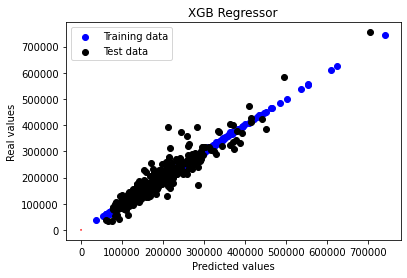

In [67]:
plot_train_test_predictions('XGB Regressor',train_predictions,test_predictions)

In [ ]:
plo